<a href="https://colab.research.google.com/github/davidfox87/neuro_encoding_models/blob/master/how_to_find_optimal_filter_length.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#@title Clone the github repository 
!git clone https://github.com/davidfox87/neuro_encoding_models
%cd neuro_encoding_models/


Cloning into 'neuro_encoding_models'...
remote: Enumerating objects: 388, done.
remote: Counting objects: 100% (388/388), done.
remote: Compressing objects: 100% (286/286), done.
remote: Total 388 (delta 212), reused 222 (delta 99), pack-reused 0
Receiving objects: 100% (388/388), 6.11 MiB | 31.92 MiB/s, done.
Resolving deltas: 100% (212/212), done.
/content/neuro_encoding_models


In [3]:
#@title add package to google colab
import sys, os
sys.path.append(os.getcwd())

In [60]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import Ridge
import utils.read as io
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from glmtools.fit import fit_nlin_hist1d
import pickle

In [5]:

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg = agg.fillna(0)
		# agg.dropna(inplace=True)
	return agg


In [6]:

# All you need in a Pipeline is any object with a fit and transform method
# that returns an array and takes the right positional arguments
# (array x, one-d optional array y)

class InsertLags(BaseEstimator, TransformerMixin):
	"""
    Automatically Insert Lags
    """

	def __init__(self, lag=1):
		self.lag = lag

	def fit(self, X, y=None):
		return self

	def transform(self, X, y=None):
		X = series_to_supervised(X, n_in=self.lag)
		return X.values



In [80]:
stim, response = io.load_mean_psth('datasets/neural/control_stim_to_orn.mat', 'control_orn')
#stim, response = io.load_mean_psth('datasets/neural/control_stim_to_pn.mat', 'control_pn')


In [81]:
fs = 100
# consider splitting by 80/20 train/validation and then make a lot of timeseries splits > 10, then test the mse on test
stim_train, stim_test, resp_train, resp_test = train_test_split(stim, response,
	 																test_size=0.001,
																	shuffle=False,
																	random_state=42)
scaler = MinMaxScaler([0, 1])
resp_train_scaled = scaler.fit_transform(resp_train.reshape(-1, 1))

print(stim_train.shape)
print(stim_test.shape)

(2497, 1)
(3, 1)


In [82]:
estimators = [('add_lags', InsertLags()),
				  ('scaler', StandardScaler()),
				  ('model', Ridge(fit_intercept=False))]

pipe = Pipeline(steps=estimators)
alphas = np.logspace(0, 20, num=10, base=2)

param_grid = {
	'model__alpha': alphas,
	'add_lags__lag': [1*fs, 2*fs, 4*fs]
}

tscv = TimeSeriesSplit(n_splits=10)
search = GridSearchCV(pipe, param_grid=param_grid, cv=tscv, verbose=1,
						  scoring='neg_mean_squared_error', n_jobs=-1,
						  return_train_score=True)

search.fit(stim_train.reshape(-1, 1), resp_train_scaled)


Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   20.5s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   45.6s finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('add_lags', InsertLags(lag=1)),
                                       ('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('model',
                                        Ridge(alpha=1.0, copy_X=True,
                                              fit_intercept=False,
                                              max_iter=None, normalize=False,
                                              random_state=None, solver='auto',
                                              tol=0.001))],
                                ve...se),
             iid='deprecated', n_jobs=-1,
             param_grid={'add_lags__lag

In [83]:
means = search.cv_results_['mean_test_score']
stds = search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, search.cv_results_['params']):
	print("%0.3f (+/-%0.03f) for %r"
			  % (mean, std * 2, params))

print("Best: %f using %s" % (search.best_score_, search.best_params_))

res = [sub['add_lags__lag'] for sub in search.cv_results_['params']]
df = pd.DataFrame({'rmse': means, 'window_length': res})
df2 = df.groupby(['window_length']).max()

-0.064 (+/-0.043) for {'add_lags__lag': 100, 'model__alpha': 1.0}
-0.062 (+/-0.041) for {'add_lags__lag': 100, 'model__alpha': 4.666116158304467}
-0.061 (+/-0.037) for {'add_lags__lag': 100, 'model__alpha': 21.772640002790034}
-0.060 (+/-0.034) for {'add_lags__lag': 100, 'model__alpha': 101.59366732596479}
-0.062 (+/-0.040) for {'add_lags__lag': 100, 'model__alpha': 474.0478526910928}
-0.069 (+/-0.056) for {'add_lags__lag': 100, 'model__alpha': 2211.9623452514425}
-0.081 (+/-0.073) for {'add_lags__lag': 100, 'model__alpha': 10321.273240738805}
-0.094 (+/-0.081) for {'add_lags__lag': 100, 'model__alpha': 48160.25984288687}
-0.102 (+/-0.083) for {'add_lags__lag': 100, 'model__alpha': 224721.36664103606}
-0.105 (+/-0.083) for {'add_lags__lag': 100, 'model__alpha': 1048576.0}
-0.060 (+/-0.054) for {'add_lags__lag': 200, 'model__alpha': 1.0}
-0.055 (+/-0.048) for {'add_lags__lag': 200, 'model__alpha': 4.666116158304467}
-0.053 (+/-0.043) for {'add_lags__lag': 200, 'model__alpha': 21.7726400

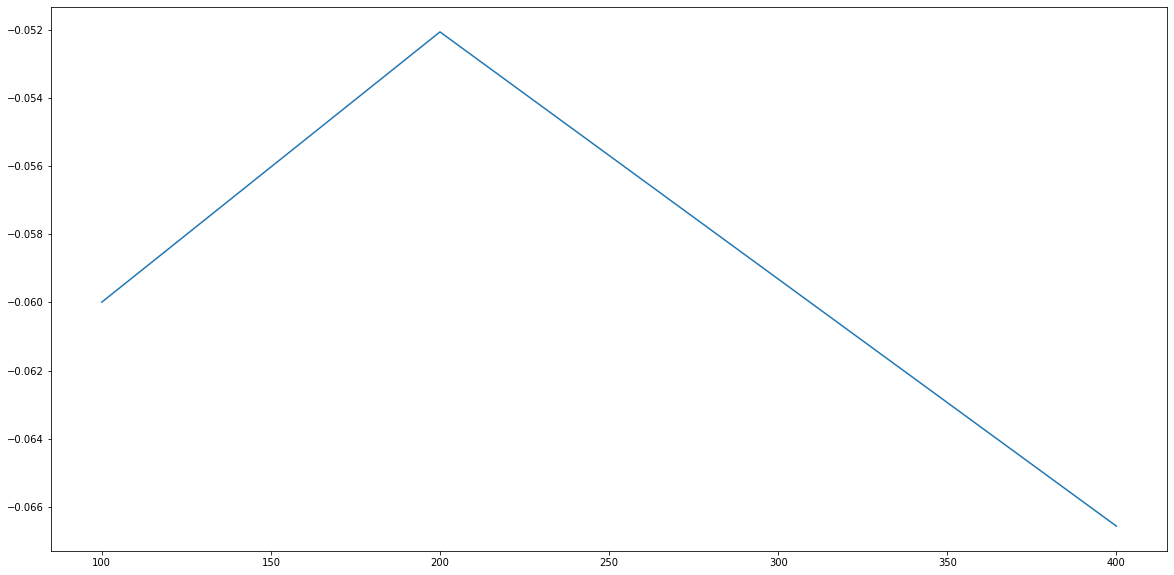

In [84]:
# plot the neg_mean_squared_error as a function of window length
plt.figure()
plt.plot(df2['rmse'])

In [85]:
estimators = [('add_lags', InsertLags(search.best_params_['add_lags__lag'])),
				  ('scaler', StandardScaler()),
				  ('model', Ridge(search.best_params_['model__alpha']))]
pipe = Pipeline(steps=estimators)

# scale the output
pipe.fit(stim_train.reshape(-1, 1), resp_train_scaled)


Pipeline(memory=None,
         steps=[('add_lags', InsertLags(lag=200)),
                ('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('model',
                 Ridge(alpha=101.59366732596479, copy_X=True,
                       fit_intercept=True, max_iter=None, normalize=False,
                       random_state=None, solver='auto', tol=0.001))],
         verbose=False)

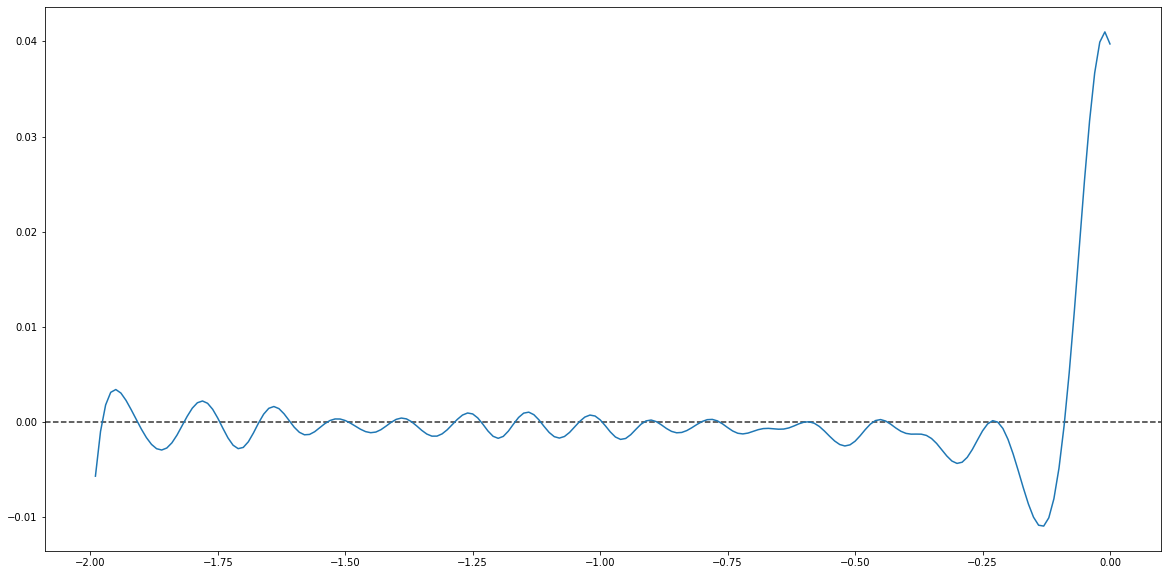

In [86]:
plt.figure()
w = pipe.named_steps['model'].coef_[0]
d = len(w[1:])
t = np.arange(-d + 1, 1) * 0.01
plt.plot(t, w[1:])
plt.axhline(0, color=".2", linestyle="--", zorder=1)


In [87]:
w.shape
stim_train = stim_train.squeeze()

In [88]:
resp_train = resp_train.squeeze()

In [89]:
#resp_train.shape
stim_train.shape

(2497,)

In [90]:
plt.figure()
w.shape
xx, fnlin, rawfilteroutput = fit_nlin_hist1d(stim_train, resp_train, w, 0.01, 50)


<Figure size 1440x720 with 0 Axes>

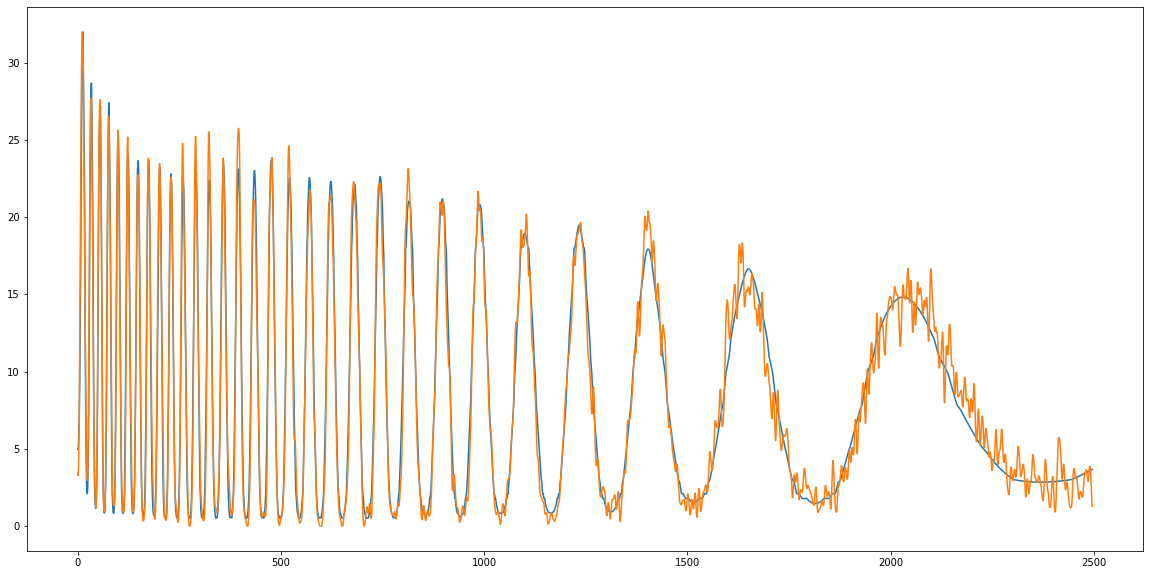

In [91]:
plt.rcParams['figure.figsize'] = [20, 10]
plt.plot(fnlin(rawfilteroutput))
plt.plot(resp_train)

In [65]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)  

In [92]:
file_name = "/content/gdrive/My Drive/orn_filter.pkl"
data = {'name': 'pn_control',
	 		'k': w[1:],
	 		'nlfun': (xx, fnlin(xx)),
			'window_length': search.best_params_['add_lags__lag']}
	
output = open(file_name, 'wb')
	
# pickle dictionary using protocol 0
pickle.dump(data, output)

In [93]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [94]:
%ls /content/gdrive/My\ Drive

 61507788835__40E57B85-A9E5-48B4-A20C-4D8AAE8B057B.MOV
'Bread baking'/
 budget2020.gsheet
 Codes.tar.gz
'Colab Notebooks'/
'Copy of DavidFoxResume.gdoc'
'Copy of NMA-pod151-presentation.gslides'
'Copy operation sheet.pdf'
 DavidFoxResumeLatest.docx
 foo.txt
 Fox_resume_04_19_2020.pdf
'Green Card Application'/
'Health Stuff'/
'insight loan Qs .gsheet'
 jobs/
 jobSearchStuff/
 KITP2018.key
'machine learning'/
 MichelleEmployersAddresses.pdf
 orn_filter.pkl
 pn_filter.pkl
'Pod 151 project brainstorming.gdoc'
'questions for angela tran.gdoc'
 SCN1588006888468.pdf
'Student Loans'/
'Tartine Bread-ElisabethPrueitt.epub'
'tax returns'/
 therapy/
'Travel documents'/
'Untitled document (1).gdoc'
'Untitled document.gdoc'
'Work Stuff'/
